In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.utils as ku

tf.config.run_functions_eagerly(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2024-09-01 22:02:49.326598: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 22:02:49.835352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 22:02:50.150464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 22:02:50.192540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 22:02:50.545177: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1


I0000 00:00:1725208373.762157   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725208374.264679   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725208374.264728   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725208374.268811   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725208374.268872   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [2]:
rawdataset = pd.read_csv("./dataset/full_dataset.csv")

In [3]:
dataset = rawdataset[:1900]
dataset = dataset.drop(["link", "source"], axis=1)

In [4]:
print("Data shape:", dataset.shape)
dataset.head()

Data shape: (1900, 5)


,Unnamed: 0,title,ingredients,directions,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [5]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in '!"#$%&*+:;<=>?@[\]^_`{}~').lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt

title = [clean_text(x) for x in dataset.title]
NER = [clean_text(x) for x in dataset.NER]
ingredients = [clean_text(x) for x in dataset.ingredients]
directions = [clean_text(x) for x in dataset.directions]

In [6]:
finaldataset = []
for i in range(len(NER)):
    finaldataset.append(NER[i]+" | "+title[i]+" | "+ingredients[i]+" | "+directions[i])
max_length = 0
for i in finaldataset:
    max_length = max(max_length, len(i))
print("max_length:", max_length)
print()
print("Recipe at index 0:\n", finaldataset[0])

max_length: 1359

Recipe at index 0:
 brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits | no-bake nut cookies | 1 c. firmly packed brown sugar, 1/2 c. evaporated milk, 1/2 tsp. vanilla, 1/2 c. broken nuts (pecans), 2 tbsp. butter or margarine, 3 1/2 c. bite size shredded rice biscuits | in a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine., stir over medium heat until mixture bubbles all over top., boil and stir 5 minutes more. take off heat., stir in vanilla and cereal mix well., using 2 teaspoons, drop and shape into 30 clusters on wax paper., let stand until firm, about 30 minutes.


In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=False,
    filters='',
    lower=False,
    split=' '
)
tokenizer.fit_on_texts(finaldataset)
tokenizer.fit_on_texts(["~"])

vocab_size = len(tokenizer.word_index) + 1
word_to_token = tokenizer.word_index
print("Total words:", vocab_size)

text = ["pineapple condensed milk lemons pecans graham cracker crusts"]
token_list = tokenizer.texts_to_sequences(text)
print(text)
print(token_list)

Total words: 7317
['pineapple condensed milk lemons pecans graham cracker crusts']
[[183, 236, 90, 2856, 246, 192, 205, 1595]]


In [8]:
finaldataset_token = tokenizer.texts_to_sequences(finaldataset)
print('Vectorized dataset size', len(finaldataset_token))

Vectorized dataset size 1900


In [9]:
tokenizer.sequences_to_texts(finaldataset_token[:2])

['brown sugar, milk, vanilla, nuts, butter, bite size shredded rice biscuits | no-bake nut cookies | 1 c. firmly packed brown sugar, 1/2 c. evaporated milk, 1/2 tsp. vanilla, 1/2 c. broken nuts (pecans), 2 tbsp. butter or margarine, 3 1/2 c. bite size shredded rice biscuits | in a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine., stir over medium heat until mixture bubbles all over top., boil and stir 5 minutes more. take off heat., stir in vanilla and cereal mix well., using 2 teaspoons, drop and shape into 30 clusters on wax paper., let stand until firm, about 30 minutes.',
 "beef, chicken breasts, cream of mushroom soup, sour cream | jewell ball's chicken | 1 small jar chipped beef, cut up, 4 boned chicken breasts, 1 can cream of mushroom soup, 1 carton sour cream | place chipped beef on bottom of baking dish., place chicken on top of beef., mix soup and cream together pour over chicken. bake, uncovered, at 275u00b0 for 3 hours."]

In [10]:
input_sequences = []
for line in finaldataset:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [11]:
max_seq_len = max(len(x) for x in input_sequences)
max_seq_len

231

In [12]:
print(input_sequences[:10])

[[51, 10], [51, 10, 36], [51, 10, 36, 65], [51, 10, 36, 65, 179], [51, 10, 36, 65, 179, 34], [51, 10, 36, 65, 179, 34, 927], [51, 10, 36, 65, 179, 34, 927, 487], [51, 10, 36, 65, 179, 34, 927, 487, 181], [51, 10, 36, 65, 179, 34, 927, 487, 181, 199], [51, 10, 36, 65, 179, 34, 927, 487, 181, 199, 677]]


In [13]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding = 'pre'))

In [14]:
features, labels = input_sequences[:, :-1], input_sequences[:, -1]

In [15]:
features.nbytes, labels.nbytes

(156737640, 681468)

In [16]:
labels = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

In [17]:
n = 0.1
slice_size = int(len(features)*n)
print("Slice size:", slice_size)

Slice size: 17036


In [18]:
np.save('./gru/features', features[:slice_size, :])
np.save('./gru/labels', labels[:slice_size])

In [19]:
features = np.load('./gru/features.npy')
labels = np.load('./gru/labels.npy')

In [20]:
features.nbytes, labels.nbytes

(15673120, 997219296)

In [21]:
def generator_model():
    model = Sequential([
    Embedding(vocab_size, 256, input_length=max_seq_len),
    GRU(126),
    Dense(vocab_size, activation='softmax')
    ])
    return model

In [22]:
model = generator_model()
model.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
              metrics = ['accuracy'])

/home/rahul/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1725208438.546761   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725208438.563499   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725208438.563559   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725208438.617208   67453 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-01 22:03:58.622251: I tensor

In [23]:
history = model.fit(features, labels, epochs = 25, batch_size=64)

/home/rahul/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-09-01 22:04:23.630215: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


267/267 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.0420 - loss: 7.3416
Epoch 2/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.1329 - loss: 5.5731
Epoch 3/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.2104 - loss: 4.6580
Epoch 4/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.2716 - loss: 3.9792
Epoch 5/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.3160 - loss: 3.4310
Epoch 6/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.3773 - loss: 2.9060
Epoch 7/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.4502 - loss: 2.4296
Epoch 8/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.5283 - loss: 2.0329
Epoch 9/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.5934 - loss: 1.7192
Epoch 10/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6483 - loss: 1.4891
Epoch 11/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.7041 - loss: 1.2504
Epoch 12/25
267/267 ━━━━━━━━━━━━━━━━━━━━ 

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 230, 256)         │     1,873,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, 126)              │       145,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 7317)             │       929,259 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,842,691 (33.73 MB)

 Trainable params: 2,947,563 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,895,128 (22.49 MB)

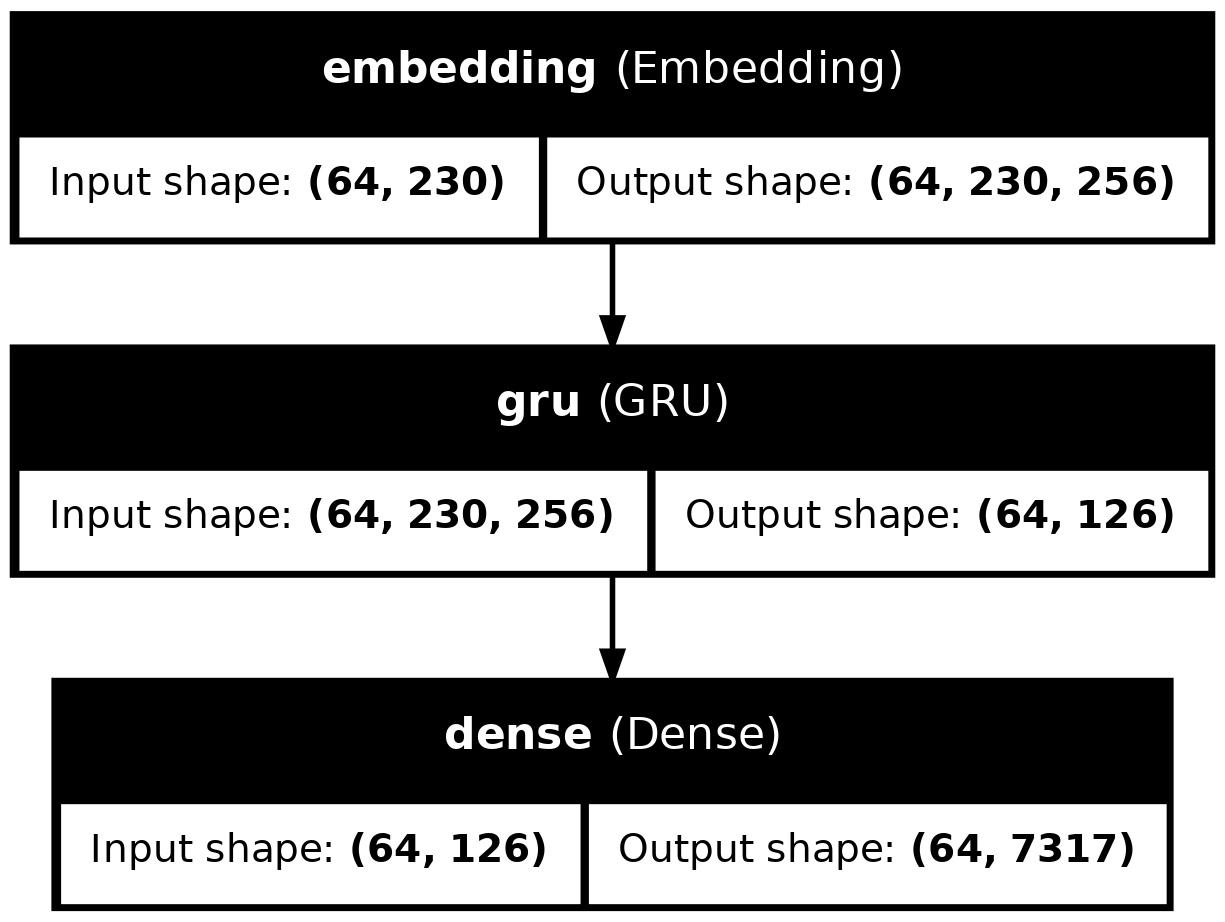

In [25]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [42]:
print("Model Accuracy:", max(history.history['accuracy']))
print("Loss:", min(history.history['loss']))

Model Accuracy: 0.9543319940567017
Loss: 0.23319125175476074


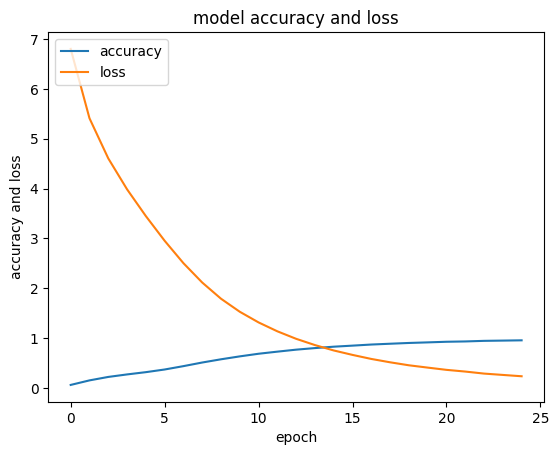

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy and loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [37]:
def generate_text(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding = "pre")
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text

In [61]:
ing = "hearts, mayonnaise, parmesan cheese"
print("Ingredients:", ing)
print("\nPredicted Recipe:")
print(generate_text(ing, 100))

Ingredients: hearts, mayonnaise, parmesan cheese

Predicted Recipe:
hearts, mayonnaise, parmesan cheese | artichoke dip | 2 cans or jars artichoke hearts, 1 c. mayonnaise, 1 c. parmesan cheese | drain artichokes and chop., mix with mayonnaise and parmesan cheese., after well mixed, bake, uncovered, for 20 to 30 minutes at 350u00b0., serve with crackers. crackers. and bake at 350u00b0 for 30 minutes. serve hot with crackers. crackers. and bake at 350u00b0 for 45 minutes. serve hot with crackers. crackers. bake at 350u00b0 for 30 minutes. serve hot with crackers. crackers. and bake at 350u00b0 for 45 minutes. serve hot with crackers. crackers. bake at 350u00b0 for 30 minutes. serve hot with


In [ ]:
print("Actual Data:")
print(finaldataset[37])
print("\nPredicted Data:")
generate_text("salad supreme, italian dressing", 100)

Actual Data:
salad supreme, italian dressing | summer spaghetti | 1 lb. very thin spaghetti, 1/2 bottle mccormick salad supreme (seasoning), 1 bottle zesty italian dressing | prepare spaghetti per package., drain., melt a little butter through it., marinate overnight in salad supreme and zesty italian dressing., just before serving, add cucumbers, tomatoes, green peppers, mushrooms, olives or whatever your taste may want.

Predicted Data:


In [ ]:
model.save("Culinary-Companion-V0.1.keras")